Данный ноутбук позаимствован с курса по Deep Learning в Сколтехе для магистров!\
Автор: Егор Бурков

Также хороший пример transfer learning приведен на [странице](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) PyTorch

# Transfer Learning

Imagine we want to train a CNN to solve some task B, and we have a CNN trained to solve task A.

We can adapt that trained CNN to solve task B. This is known as **transfer learning**. Transfer learning from a complex task A is almost always better than training from scratch for task B; it prevents overfitting and increases accuracy. We will review three methods of transfer learning.

The rest of this notebook will guide you through the following:

1. Review the target task B (telling apart architectural heritage elements on images).
2. Download a CNN that has been pretrained to solve a far more complex task A (1000-class [ImageNet](http://image-net.org/) classification).
3. Try classifying CNN's outputs by classical machine learning to solve task B (use CNN as a black box feature extractor).
4. Replace CNN's last layers and train only them for task B.
5. Train (*fine-tune*) the whole network for task B.

*(service code)* Import libraries.

In [1]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

import torch
import torchvision

### 1. Architectural Heritage Elements Dataset

*(service code)* Download the dataset.

In [2]:
from pathlib import Path

DATASET_ROOT = Path("Architectural_Heritage_Elements_Dataset_128(creative_commons)")

if not (DATASET_ROOT / "train").is_dir():
    !gdown --id 1X38ZkQnox_k0BaYtMlApFmT7oxAK_c9F

    ARCHIVE_NAME = Path("architectural_heritage_elements.zip")
    assert ARCHIVE_NAME.is_file(), f"Couldn't download {ARCHIVE_NAME} doesn't exist"

    print("Unzipping...")
    import zipfile
    with zipfile.ZipFile(ARCHIVE_NAME, 'r') as archive:
        archive.extractall(".")

Downloading...
From: https://drive.google.com/uc?id=1X38ZkQnox_k0BaYtMlApFmT7oxAK_c9F
To: /content/architectural_heritage_elements.zip
100% 86.1M/86.1M [00:00<00:00, 99.5MB/s]
Unzipping...


*(service code)* Split the dataset into training and validation sets.

In [3]:
import random
random.seed(666)

num_val_images_per_label = 120

if not (DATASET_ROOT / 'val').is_dir():
    labels = sorted(x.name for x in DATASET_ROOT.iterdir())

    for label in labels:
        for split in 'train', 'val':
            (DATASET_ROOT / split / label).mkdir(parents=True)

        images = sorted((DATASET_ROOT / label).iterdir())
        random.shuffle(images)

        val_images   = images[:num_val_images_per_label]
        train_images = images[num_val_images_per_label:]
        
        for split, images in ('train', train_images), ('val', val_images):
            for image in images:
                image.rename(DATASET_ROOT / split / label / image.name)
                
        (DATASET_ROOT / label).rmdir()

Now we have images grouped in folders by train/val split and then by class, like this:

In [4]:
!ls "Architectural_Heritage_Elements_Dataset_128(creative_commons)/train/"

 altar	 bell_tower  'dome(inner)'   flying_buttress   stained_glass
 apse	 column      'dome(outer)'   gargoyle	       vault


`torchvision.datasets.ImageFolder` is a handy class to load images from disk.

In [5]:
train_dataset = torchvision.datasets.ImageFolder(DATASET_ROOT / 'train')
val_dataset   = torchvision.datasets.ImageFolder(DATASET_ROOT / 'val')

`ImageFolder` is a special case of a very important class `torch.utils.data.Dataset`.

Any `Dataset` supports `len()` and indexing:

In [6]:
print(f"{len(train_dataset)} training images")
print(f"{len(  val_dataset)} validation images")

image, label = train_dataset[50]
print(f"Dataset returns {type(image)} and {type(label)}\n")

class_names = train_dataset.classes

9035 training images
1200 validation images
Dataset returns <class 'PIL.Image.Image'> and <class 'int'>



Let's explore the dataset.

stained_glass
Image size: (128, 128)


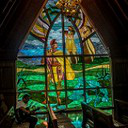

In [7]:
image, label = train_dataset[8000]
print(class_names[label])
print("Image size:", image.size)

image

### 2. CNNs pretrained on the *ImageNet* dataset

#### 2.1 The ImageNet challenge

In ImageNet, there are ~1M images of 1000 classes.

Download the class labels.

In [8]:
import urllib.request
import json

LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
with urllib.request.urlopen(LABELS_URL) as f:
    imagenet_class_names = json.loads(f.read().decode())

print(f"There are {len(imagenet_class_names)} classes in ImageNet")

There are 1000 classes in ImageNet


Explore those classes.

In [9]:
import random

print("10 random ImageNet classes:\n")
for _ in range(10):
    class_idx = random.randint(0, len(imagenet_class_names))
    print("Class %d: %s" % (class_idx, imagenet_class_names[class_idx]))

10 random ImageNet classes:

Class 301: ladybug
Class 322: ringlet
Class 836: sunglass
Class 423: barber chair
Class 411: apron
Class 138: bustard
Class 679: necklace
Class 534: dishwasher
Class 814: motorboat
Class 44: alligator lizard


#### 2.2 Pretrained CNNs

`torchvision.models` [provides](https://pytorch.org/docs/stable/torchvision/models.html) pretrained CNNs, including those trained on ImageNet.

Let's use for example the "[SqueezeNet 1.1](https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py)" CNN.

In [10]:
help(torchvision.models.squeezenet1_1)

Help on function squeezenet1_1 in module torchvision.models.squeezenet:

squeezenet1_1(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> torchvision.models.squeezenet.SqueezeNet
    SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr



<img src="https://cdn-images-1.medium.com/max/800/1*xji5NAhX6m3Nk7BmR_9GFw.png" width=650>

Download pretrained weights and create the CNN.

In [11]:
model = torchvision.models.squeezenet1_1(
    pretrained=True,
    num_classes=1000)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

In [12]:
print(model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

* If you only want to evaluate the model, call `.eval()`.
* If you want to train the model, call `.train()`.

This is needed because some layers behave differently during
training and testing, for instance dropout or batch normalization.

In [13]:
model.eval();

Also, if you don't train (i.e. don't need gradients with respect to parameters), call `.requires_grad_(False)` to save memory.

In [14]:
model.requires_grad_(False);

First, let's try to forward some garbage through the model.

We will have to use images at least of size $224 \times 224$ pixels, [read in the docs why](https://pytorch.org/vision/stable/models.html).

In [15]:
# A mini-batch of 5 random images
sample_input = torch.randn(5, 3, 224, 224)
sample_output = model(sample_input)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


The output is class scores (not probabilities yet).

The higher the $i$-th score, the higher the CNN's confidence that this image is of $i$-th class.

In [16]:
print(
    f"The CNN has returned a tensor of {sample_output.shape} "
    f"with values from {sample_output.min().item()} to {sample_output.max().item()}"
)

The CNN has returned a tensor of torch.Size([5, 1000]) with values from 0.0 to 14.553211212158203


Now time to forward some real images through the CNN.

Before that, they have to be normalized [as per the documentation](https://pytorch.org/vision/stable/models.html):

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:

In [17]:
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

In [18]:
import PIL.Image

def predict(image):
    """
    image:
        PIL.Image

    return:
        tensor, shape == (1000,)
        ImageNet class probabilities.
    """
    # Scale the image to 224x224 pixels
    print('before resize:', image.size)
    image = image.resize((224, 224))
    print('after resize:', image.size)

    # Convert `PIL.Image` to `torch.tensor` and normalize
    image = torchvision.transforms.ToTensor()(image)
    image = normalize(image)
    
    # Add singleton batch dimension with [None]
    image = image[None]
    
    # Predict class scores
    prediction = model(image)
    
    # Convert class scores to probabilities
    prediction = prediction.softmax(1)
    
    # Remove singleton batch dimension
    return prediction[0]

Try to classify some real images.

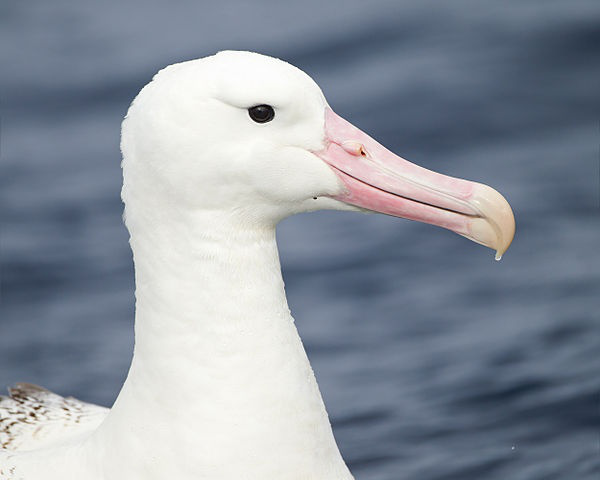

In [19]:
import urllib

IMAGE_URL = "http://qph.fs.quoracdn.net/main-qimg-3c711f9ad560f1703125f2839f5d8ad6"
# IMAGE_URL = "http://bestfunnies.com/wp-content/uploads/2015/05/TOP-30-Cute-Cats-Cute-Cat-2-570x428.jpg"
# IMAGE_URL = "https://i.pinimg.com/originals/23/dd/90/23dd903fc557cfbc95f0176c24829c95.jpg"
# IMAGE_URL = "https://i.pinimg.com/474x/6e/d3/0c/6ed30c47246083096f0d9b79e122dace.jpg"

with urllib.request.urlopen(IMAGE_URL) as f:
    image = PIL.Image.open(f)

image

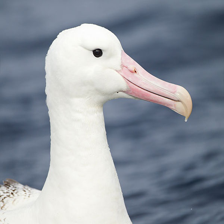

In [20]:
image.resize((224, 224))

In [21]:
probabilities = predict(image)

top_probabilities, top_indices = torch.topk(probabilities, 10)
print("10 most probable classes are:")
for probability, class_idx in zip(top_probabilities, top_indices):
    print("%.4f: %s" % (probability, imagenet_class_names[class_idx]))

before resize: (600, 480)
after resize: (224, 224)
10 most probable classes are:
0.9977: albatross
0.0020: goose
0.0002: great egret
0.0001: spoonbill
0.0000: crane (bird)
0.0000: pelican
0.0000: flamingo
0.0000: white stork
0.0000: ptarmigan
0.0000: weasel


### 3. Use classical machine learning with a pretrained CNN

Our network is some convolutional part `model.features` followed by a classification block `model.classifier` (you learn this by reading model's `forward()` in its [source code](https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py)).

`model.features` outputs a stack of 512 uninterpretable feature maps, of size $20 \times 20$ in this case:

In [22]:
sample_input = torch.randn(5, 3, 333, 333)
model.features(sample_input).shape

torch.Size([5, 512, 20, 20])

Which are then passed through this `model.classifier` block:

In [23]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)

Although the outputs of `model.features` are uninterpretable, they contain a lot of useful information about input images. They are called *latent encodings* or *latent embeddings* of the input images, or *intermediate features* (hence the name `model.features`).

Here is an example visualization of these features ([source](https://www.researchgate.net/figure/t-SNE-embedding-of-a-subset-of-the-convolutional-features-extracted-from-Imagenet_fig1_283762714)):

![](https://www.researchgate.net/profile/Zhongfei_Zhang/publication/283762714/figure/fig1/AS:614293271756808@1523470337103/t-SNE-embedding-of-a-subset-of-the-convolutional-features-extracted-from-Imagenet.png)

These features can be sufficient to recognize architectural elements in images. Let's train a random forest classifier on these features.

Sometimes it's called "using a CNN as a *black-box feature extractor*".

First, implement image preprocessing.

Images have to be of same size ($224 \times 224$ in our case) for efficiency: we will stack them in tensors of size $B \times 3 \times 224 \times 224$ representing mini-batches.

In [24]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]) 
])

train_dataset_224 = torchvision.datasets.ImageFolder(DATASET_ROOT / 'train', transform)
val_dataset_224   = torchvision.datasets.ImageFolder(DATASET_ROOT / 'val'  , transform)

image, _ = train_dataset_224[66]
print(f"Datasets now return images as tensors of size {image.shape} and datatype {image.dtype}")

assert \
    torch.is_tensor(image) and \
    image.dtype == torch.float32 and \
    image.shape == (3, 224, 224)

Datasets now return images as tensors of size torch.Size([3, 224, 224]) and datatype torch.float32


For even better efficiency, we use `torch.utils.data.DataLoader` class. It is a wrapper around `torch.utils.data.Dataset` that automatically loads data in the background and groups them into batches.

In [25]:
??torch.utils.data.DataLoader

In [26]:
BATCH_SIZE = 24
NUM_WORKERS = 2

train_dataloader = torch.utils.data.DataLoader(
    train_dataset_224, batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS, shuffle=True, pin_memory=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset_224, batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS, shuffle=False, pin_memory=True)

print(f"Train/val dataloaders have {len(train_dataloader)} and {len(val_dataloader)} batches")

Train/val dataloaders have 377 and 50 batches


Upload the model to GPU (if it's available).

In [27]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [28]:
model.to(DEVICE)

assert str(list(model.parameters())[0].device) == DEVICE

Compute embeddings for the whole dataset.

Also, let's average the features over spatial dimensions (i.e. apply *global average pooling*). We do this because we don't care in which part of an image a cat/dog was, but rather "how much of a cat/dog" there was.

This way we encode every image with a **512-dimensional vector**. (in the image below, $d$ could be 512)

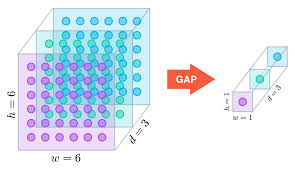

Below let us run `features` part of our net in order to extract latent embeddings. Next we avearge outputs over spatial dimensions and end up one dimensional vector

In [29]:
def compute_embeddings(dataloader):
    """
    Compute latent embeddings for all images in `dataloader` using `model` CNN.
    
    dataloader:
        torch.utils.data.DataLoader
    
    return:
    X:
        tensor, shape: (len(dataloader.dataset), 512), dtype: float32, device: 'cpu'
    y:
        tensor, shape: (len(dataloader.dataset),)    , dtype: int64  , device: 'cpu'
    """
    X, y = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            y.append(labels)

            features = model.features(images.to(DEVICE)).mean([2, 3]) # (B, 512, 13, 13)
            print(features.shape)
            X.append(features.cpu())

    return torch.cat(X), torch.cat(y)

In [30]:
images, _ = iter(train_dataloader).next()
features = model.features(images.to(DEVICE)).mean([2, 3]) # (B, 512, 13, 13)
print(features.shape)  # the shape of tensor representing 1 batch

torch.Size([24, 512])


In [31]:
X_train, y_train = compute_embeddings(train_dataloader)
X_val  , y_val   = compute_embeddings(val_dataloader)

  0%|          | 0/377 [00:00<?, ?it/s]

torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size

  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size([24, 512])
torch.Size

In [32]:
assert X_train.shape == (len(train_dataloader.dataset), 512)
assert y_train.shape == (len(train_dataloader.dataset),)
assert X_val.shape   == (len(val_dataloader.dataset), 512)
assert y_val.shape   == (len(val_dataloader.dataset),)

In [33]:
len(train_dataloader.dataset), len(val_dataloader.dataset)

(9035, 1200)

Train the random forest classifier on the embeddings that we just precomputed.

In [34]:
import sklearn.ensemble
import sklearn.metrics

classifier = sklearn.ensemble.RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:
train_accuracy = sklearn.metrics.accuracy_score(y_train, classifier.predict(X_train))
val_accuracy   = sklearn.metrics.accuracy_score(y_val  , classifier.predict(X_val))

print(f"Train accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")

Train accuracy: 99.97%
Validation accuracy: 86.08%


### 4. Replace the last layers and retrain them

The above approach isn't very convenient because we have to run a separate algorithm.

It's more convenient to add a neural network on top of `model.CNN` instead of a random forest. This way, our pipeline becomes **end-to-end**: a single `torch.nn.Module` directly outputs the prediction we need (10 class scores).

Still, don't expect the accuracy to be much higher than with random forest. We just replaced it with a simple two-layer neural net, nothing more.

In [36]:
class RetrofittedCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        pretrained_net = torchvision.models.squeezenet1_1(
            pretrained=True,
            num_classes=1000)
        self.CNN = pretrained_net.features

        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, len(class_names))
        )

    def forward(self, images):
        """
        Define the forward pass.
        """
        features = self.CNN(images).mean([2, 3])
        return self.classifier(features)

torch.manual_seed(666) # for reproducibility
model = RetrofittedCNN().to(DEVICE)
model.CNN.requires_grad_(False);

Set the optimization parameters.

Note that we only want to train the classifier!

**Importnat:** here we freeze weights of `CNN` part in order not to train its weihgts. It is achieved by passing only needed part weights to an optimizer

In [37]:
trainable_parameters = model.classifier.parameters()

learning_rate = 3e-3
optimizer = torch.optim.Adam(
    trainable_parameters, lr=learning_rate, weight_decay=1e-4)

# Our loss function is negative log likelihood of the correct class
criterion = torch.nn.CrossEntropyLoss()

Describe the training loop.

In [38]:
# Please read this cell and understand what's going on!

def validate(model, dataloader):
    """Compute accuracy on the `dataloader` dataset."""
    model.eval()

    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            labels = labels.to(DEVICE)
            probabilities = model(images.to(DEVICE))
            predictions = probabilities.max(1)[1]

            total += len(labels)
            correct += (predictions == labels).sum().item()
            
    return correct / total

def train(model, dataloader, criterion, optimizer):
    """Train for one epoch, return accuracy and average loss."""
    model.train()

    correct, total = 0, 0
    total_loss = 0.0

    for images, labels in tqdm(dataloader):
        probabilities = model(images.to(DEVICE))

        with torch.no_grad():
            labels = labels.to(DEVICE)
            predictions = probabilities.max(1)[1]
            
            total += len(labels)
            correct += (predictions == labels).sum().item()

        loss_value = criterion(probabilities, labels)
        total_loss += loss_value.item() * len(labels)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
    
    return correct / total, total_loss / total

In [39]:
def set_learning_rate(optimizer, new_learning_rate):
    """Set learning rates of the optimizer to `new_learning_rate`."""
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_learning_rate

In [40]:
epochs = 0
train_accuracy, val_accuracy, train_loss = float('nan'), float('nan'), float('nan')

In [41]:
images, labels = iter(train_dataloader).next()
probabilities = model(images.to(DEVICE))
print(probabilities.shape)
predictions = probabilities.max(1)[1]

torch.Size([24, 10])


In [ ]:
for _ in range(15):
    # Compute validation accuracy
    val_accuracy = validate(model, val_dataloader)
    print(
        f"After {epochs} epochs, training accuracy: {train_accuracy * 100:.2f}%"
        f" (loss {train_loss:.4f}), validation accuracy: {val_accuracy * 100:.2f}%")

    # Train for one epoch
    train_accuracy, train_loss = train(model, train_dataloader, criterion, optimizer)
    epochs += 1

    # Decrease learning rate sometimes
    if epochs in (8, 12, 14):
        learning_rate /= 10
        set_learning_rate(optimizer, learning_rate)
        print(f"Decreasing the learning rate to {learning_rate}")

# Compute final validation accuracy
val_accuracy = validate(model, val_dataloader)
print(
    f"After {epochs} epochs, training accuracy: {train_accuracy * 100:.2f}%"
    f" (loss {train_loss:.4f}), validation accuracy: {val_accuracy * 100:.2f}%")

After 0 epochs, training accuracy: nan% (loss nan), validation accuracy: 12.08%


  0%|          | 0/377 [00:00<?, ?it/s]

After 1 epochs, training accuracy: 82.39% (loss 0.5383), validation accuracy: 91.17%


  0%|          | 0/377 [00:00<?, ?it/s]

After 2 epochs, training accuracy: 86.09% (loss 0.4192), validation accuracy: 90.50%


  0%|          | 0/377 [00:00<?, ?it/s]

After 3 epochs, training accuracy: 87.28% (loss 0.3830), validation accuracy: 92.08%


  0%|          | 0/377 [00:00<?, ?it/s]

After 4 epochs, training accuracy: 87.36% (loss 0.3707), validation accuracy: 92.67%


  0%|          | 0/377 [00:00<?, ?it/s]

After 5 epochs, training accuracy: 88.47% (loss 0.3447), validation accuracy: 91.67%


  0%|          | 0/377 [00:00<?, ?it/s]

After 6 epochs, training accuracy: 88.38% (loss 0.3392), validation accuracy: 92.25%


  0%|          | 0/377 [00:00<?, ?it/s]

After 7 epochs, training accuracy: 88.54% (loss 0.3387), validation accuracy: 92.00%


  0%|          | 0/377 [00:00<?, ?it/s]

Decreasing the learning rate to 0.00030000000000000003
After 8 epochs, training accuracy: 88.92% (loss 0.3307), validation accuracy: 92.42%


  0%|          | 0/377 [00:00<?, ?it/s]

After 9 epochs, training accuracy: 89.15% (loss 0.3127), validation accuracy: 92.58%


  0%|          | 0/377 [00:00<?, ?it/s]

After 10 epochs, training accuracy: 90.49% (loss 0.2863), validation accuracy: 92.75%


  0%|          | 0/377 [00:00<?, ?it/s]

After 11 epochs, training accuracy: 90.16% (loss 0.2828), validation accuracy: 92.58%


  0%|          | 0/377 [00:00<?, ?it/s]

Decreasing the learning rate to 3.0000000000000004e-05
After 12 epochs, training accuracy: 89.86% (loss 0.2942), validation accuracy: 92.50%


  0%|          | 0/377 [00:00<?, ?it/s]

After 13 epochs, training accuracy: 90.81% (loss 0.2665), validation accuracy: 92.67%


  0%|          | 0/377 [00:00<?, ?it/s]

Decreasing the learning rate to 3.0000000000000005e-06
After 14 epochs, training accuracy: 90.61% (loss 0.2731), validation accuracy: 92.83%


  0%|          | 0/377 [00:00<?, ?it/s]

After 15 epochs, training accuracy: 90.66% (loss 0.2697), validation accuracy: 93.33%


It looks like the neural network classifier generalizes better than random forest. Anyway, they all are limited by the "frozen" CNN.

### 5. Fine-tune the whole network

We have seen that `model.features` is already a good feature extractor. Still, it's not aware of our dataset.

Let's train **all** layers (including our new retrofitted classifier) to get extra accuracy. This process is called **fine-tuning**.

Because the original `model.features`' weights are valuable, fragile and co-adapted, fine-tuning requires several precautions:

* If the retrofitted classifier's weights are random, it will propagate large gradients into the pre-trained CNN. That can wreck the pre-trained weights. That's why one should either
  * train the retrofitted classifier alone for a while (**we've just done this**); or
  * assign a larger learning rate to the classifier and a smaller one to pre-trained weights (e.g. $10^{-2}$ and $10^{-4}$ with SGD); or
  * (an option for the lazy) train everything with a reduced learning rate (e.g. $10^{-3}$).
* Use a less aggressive optimizer, e.g. momentum SGD, Adam with warm-up (**we do this below**), or RAdam.
* Use a smaller learning rate than usually. **Below I used $\leq 10^{-4}$**, while on random weights I'd use something around $10^{-3}$.

In [42]:
# Don't forget to turn gradient computing back on.
# We "froze" the CNN above. "Unfreeze" it.
model.CNN.requires_grad_(True);

In [49]:
# model.CNN

Here, we set zero learning rate to warm Adam up.

Warm-up means running some iterations without any weight updates, just to let Adam accumulate gradient statistics. Otherwise, its first optimization steps will be very noisy and destructive for the pre-trained weights.

In [50]:
# Now the parameters have to include both CNN's and classifier's weights
trainable_parameters = model.parameters()

learning_rate = 0
optimizer = torch.optim.Adam(
    trainable_parameters, lr=learning_rate, weight_decay=1e-4)

Run 1 epoch of warm-up.


In [51]:
train(model, train_dataloader, criterion, optimizer);

  0%|          | 0/377 [00:00<?, ?it/s]

Switch back to a positive learning rate. Remember, it should be smaller than usual (above, we used $3 \cdot 10^{-3}$).

In [52]:
learning_rate = 1e-4
set_learning_rate(optimizer, learning_rate)

Finally, fine-tune the model.

In [53]:
epochs = 0
train_accuracy, val_accuracy, train_loss = float('nan'), float('nan'), float('nan')

In [ ]:
# Your code here
# Copy the training loop from above.
# - Train for 15 epochs.
# - Drop learning rate by a factor of 10 at epochs 7 and 12.

epoch_number = 15
for _ in range(epoch_number):
    # Compute validation accuracy
    val_accuracy = validate(model, val_dataloader)
    print(
        f"After {epochs} epochs, training accuracy: {train_accuracy * 100:.2f}%"
        f" (loss {train_loss:.4f}), validation accuracy: {val_accuracy * 100:.2f}%")

    # Train for one epoch
    train_accuracy, train_loss = train(model, train_dataloader, criterion, optimizer)
    epochs += 1

    # Decrease learning rate sometimes
    if epochs in (7, 12):
        learning_rate /= 10
        set_learning_rate(optimizer, learning_rate)
        print(f"Decreasing the learning rate to {learning_rate}")

# Compute final validation accuracy
val_accuracy = validate(model, val_dataloader)
print(
    f"After {epochs} epochs, training accuracy: {train_accuracy * 100:.2f}%"
    f" (loss {train_loss:.4f}), validation accuracy: {val_accuracy * 100:.2f}%")

After 0 epochs, training accuracy: nan% (loss nan), validation accuracy: 13.83%


  0%|          | 0/377 [00:00<?, ?it/s]

After 1 epochs, training accuracy: 73.86% (loss 0.9492), validation accuracy: 82.75%


  0%|          | 0/377 [00:00<?, ?it/s]

After 2 epochs, training accuracy: 88.87% (loss 0.4272), validation accuracy: 85.00%


  0%|          | 0/377 [00:00<?, ?it/s]

After 3 epochs, training accuracy: 91.40% (loss 0.3016), validation accuracy: 91.67%


  0%|          | 0/377 [00:00<?, ?it/s]

After 4 epochs, training accuracy: 93.17% (loss 0.2437), validation accuracy: 92.25%


  0%|          | 0/377 [00:00<?, ?it/s]

After 5 epochs, training accuracy: 94.38% (loss 0.1988), validation accuracy: 93.25%


  0%|          | 0/377 [00:00<?, ?it/s]

After 6 epochs, training accuracy: 95.34% (loss 0.1661), validation accuracy: 90.17%


  0%|          | 0/377 [00:00<?, ?it/s]

Decreasing the learning rate to 1e-05
After 7 epochs, training accuracy: 95.92% (loss 0.1416), validation accuracy: 92.83%


  0%|          | 0/377 [00:00<?, ?it/s]

After 8 epochs, training accuracy: 97.20% (loss 0.0987), validation accuracy: 94.00%


  0%|          | 0/377 [00:00<?, ?it/s]

After 9 epochs, training accuracy: 97.54% (loss 0.0862), validation accuracy: 93.83%


  0%|          | 0/377 [00:00<?, ?it/s]

After 10 epochs, training accuracy: 97.83% (loss 0.0795), validation accuracy: 94.50%


  0%|          | 0/377 [00:00<?, ?it/s]

After 11 epochs, training accuracy: 98.10% (loss 0.0762), validation accuracy: 94.58%


  0%|          | 0/377 [00:00<?, ?it/s]

Decreasing the learning rate to 1.0000000000000002e-06
After 12 epochs, training accuracy: 98.14% (loss 0.0750), validation accuracy: 94.08%


  0%|          | 0/377 [00:00<?, ?it/s]

After 13 epochs, training accuracy: 98.25% (loss 0.0693), validation accuracy: 94.58%


  0%|          | 0/377 [00:00<?, ?it/s]

After 14 epochs, training accuracy: 98.20% (loss 0.0702), validation accuracy: 94.58%


  0%|          | 0/377 [00:00<?, ?it/s]

After 15 epochs, training accuracy: 98.14% (loss 0.0686), validation accuracy: 94.50%


In [ ]:
epoch_number = 15
torch.save(model.state_dict(), f'weights_{epoch_number}.pth')